In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='')

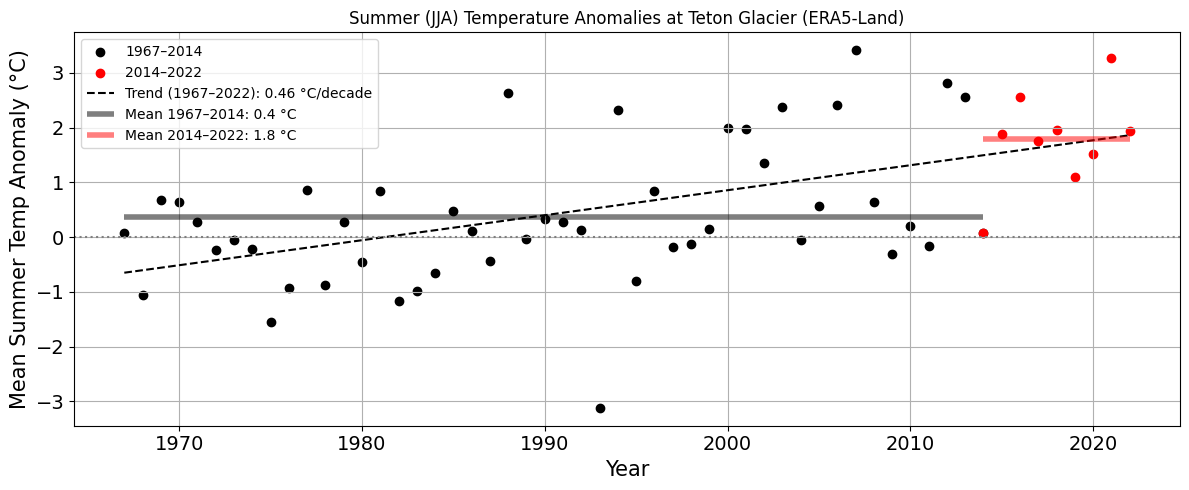

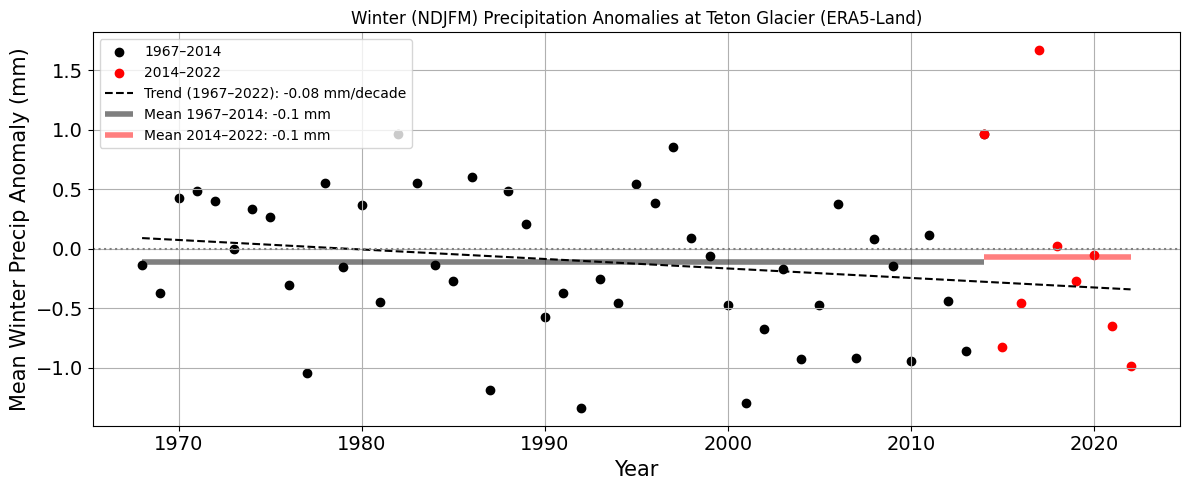

In [7]:
# === ERA5-Land anomalies → seasonal means (complete seasons only) → final plots ===
import ee
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

POINT = ee.Geometry.Point([-110.803, 43.750])  # Teton Glacier
DATA_START = '1967-01-01'
DATA_END   = '2022-12-31'


CLIM_START = '1951-01-01'
CLIM_END   = '2000-12-31'

# --- Load ERA5-Land monthly ---
era5 = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
        .select(['temperature_2m', 'total_precipitation'])
        .filterBounds(POINT)
        .filterDate(DATA_START, DATA_END))

# --- Monthly climatology (baseline) ---
def monthly_climatology(ic, start=CLIM_START, end=CLIM_END):
    clim_ic = ic.filterDate(start, end)
    months = ee.List.sequence(1, 12)

    def _monthly(m):
        m = ee.Number(m)
        sel = clim_ic.filter(ee.Filter.calendarRange(m, m, 'month'))
        return (sel.mean()
                .set('month', m)
                .select(['temperature_2m','total_precipitation']))
    return ee.ImageCollection.fromImages(months.map(_monthly))

clim_ic = monthly_climatology(era5)

# --- Add anomalies (image - monthly climatology) ---
def add_anoms(img):
    m = ee.Date(img.get('system:time_start')).get('month')
    clim = clim_ic.filter(ee.Filter.eq('month', m)).first()
    temp_anom = img.select('temperature_2m').subtract(clim.select('temperature_2m')).rename('temp_anomaly')  # K diff = °C diff
    precip_anom = img.select('total_precipitation').subtract(clim.select('total_precipitation')).rename('precip_anomaly')  # meters/month
    return (img.addBands([temp_anom, precip_anom])
               .select(['temp_anomaly','precip_anomaly'])
               .copyProperties(img, ['system:time_start']))

anom_ic = era5.map(add_anoms)

# --- Extract point time series ---
def ic_to_series(ic, band):
    def to_feat(img):
        val = img.select(band).reduceRegion(ee.Reducer.mean(), geometry=POINT, scale=1000).get(band)
        return ee.Feature(None, {
            'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
            'value': val
        })
    fc = ee.FeatureCollection(ic.map(to_feat))
    data = fc.getInfo()['features']
    rows = [{'date': dt.datetime.strptime(f['properties']['date'], '%Y-%m-%d'),
             'value': f['properties']['value']} for f in data if f['properties']['value'] is not None]
    df = pd.DataFrame(rows).sort_values('date').reset_index(drop=True)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    return df

temp_monthly = ic_to_series(anom_ic, 'temp_anomaly')     # °C anomalies
precip_monthly = ic_to_series(anom_ic, 'precip_anomaly') # meters anomalies

# --- Seasonal aggregation with COMPLETE seasons only ---
def seasonal_mean_complete(df, months, label):
    out = df.copy()
    # Assign December to next year for NDJFM
    is_winter = set(months) == {11,12,1,2,3}
    if is_winter:
        out.loc[out['month'] == 12, 'year'] = out.loc[out['month'] == 12, 'year'] + 1
    out = out[out['month'].isin(months)]
    # keep years that have all required months
    needed = len(months)
    counts = out.groupby('year')['month'].nunique()
    full_years = counts[counts == needed].index
    out = out[out['year'].isin(full_years)]
    res = (out.groupby('year', as_index=False)['value'].mean()
              .rename(columns={'value':'value'}))
    res['season'] = label
    return res

# JJA temperature anomaly (°C)
summer_temp_avg = seasonal_mean_complete(temp_monthly, [6,7,8], 'JJA')
# NDJFM precipitation anomaly (meters -> will scale to mm at plot time)
winter_precip_avg = seasonal_mean_complete(precip_monthly, [11,12,1,2,3], 'NDJFM')

# Limit to exact analysis range
summer_temp_avg = summer_temp_avg[(summer_temp_avg['year'] >= 1967) & (summer_temp_avg['year'] <= 2022)].reset_index(drop=True)
winter_precip_avg = winter_precip_avg[(winter_precip_avg['year'] >= 1967) & (winter_precip_avg['year'] <= 2022)].reset_index(drop=True)

# --- Plotter (single full-period trend, period means) ---
def plot_with_single_trend_and_means(df, ylabel, title, unit, scale=1, save_path=None):
    x = df['year'].values
    y = df['value'].values * scale

    mask_67_14 = df['year'] <= 2014
    mask_14_22 = (df['year'] >= 2014) & (df['year'] <= 2022)
    x1, y1 = x[mask_67_14], y[mask_67_14]
    x2, y2 = x[mask_14_22], y[mask_14_22]

    # Trend over full period
    slope, intercept = np.polyfit(x, y, 1)
    trend = slope * x + intercept
    slope_per_decade = slope * 10

    plt.figure(figsize=(12,5))
    plt.scatter(x1, y1, color='black', label='1967–2014')
    plt.scatter(x2, y2, color='red', label='2014–2022')
    plt.plot(x, trend, color='black', linestyle='--',
             label=f'Trend (1967–2022): {slope_per_decade:.2f} {unit}/decade')

    if len(y1) > 0:
        mean1 = np.mean(y1)
        plt.hlines(mean1, xmin=min(x1), xmax=max(x1), color='black', alpha=0.5, linewidth=4,
                   label=f'Mean 1967–2014: {mean1:.1f} {unit}')
    if len(y2) > 0:
        mean2 = np.mean(y2)
        plt.hlines(mean2, xmin=min(x2), xmax=max(x2), color='red', alpha=0.5, linewidth=4,
                   label=f'Mean 2014–2022: {mean2:.1f} {unit}')

    plt.axhline(0, color='gray', linestyle=':')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()

# --- Make the two plots ---
plot_with_single_trend_and_means(
    summer_temp_avg,
    ylabel='Mean Summer Temp Anomaly (°C)',
    title='Summer (JJA) Temperature Anomalies at Teton Glacier (ERA5-Land)',
    unit='°C',
    scale=1,
    save_path='summer_temp_anomalies.jpg'
)

plot_with_single_trend_and_means(
    winter_precip_avg,
    ylabel='Mean Winter Precip Anomaly (mm)',
    title='Winter (NDJFM) Precipitation Anomalies at Teton Glacier (ERA5-Land)',
    unit='mm',
    scale=1000,  # meters -> mm
    save_path='winter_precip_anomalies.jpg'
)


